### Import Library

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from tqdm import tqdm
import torchsummary

### Import data

앞서 2장때 이미지를 불러오는 방법을 배웠습니다.

이를 이용하여 torch를 이용하여 딥러닝에 학습을 시킬 수 있는 형태로 바꾸어주도록 하겠습니다.

In [12]:
import tensorflow as tf
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='flower_photos', 
                                   untar=True,
                                   )
data_dir = pathlib.Path(data_dir)

In [13]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import transforms as T
t = T.Compose([T.Resize((224,224)),T.ToTensor(),T.Normalize((0.5,0.5,0.5), (0.25,0.25,0.25))])
dataset = ImageFolder(root = data_dir,transform = t)

In [14]:
train_size = int(dataset.__len__() * 0.8)
valid_size = dataset.__len__() - train_size

training_data, valid_data = random_split(dataset, [train_size, valid_size])

train_loader = DataLoader(training_data, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=16, shuffle=False)

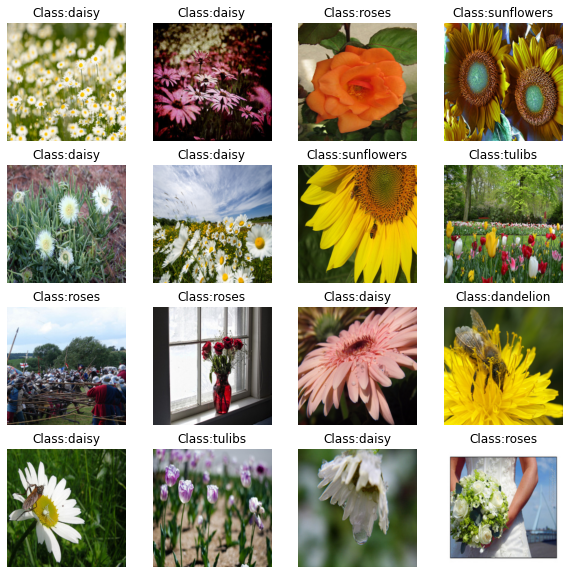

In [15]:
class_names = ['daisy','dandelion','roses','sunflowers','tulibs']
plt.figure(figsize=(10, 10))
images, labels = next(iter(train_loader))
for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  img = images[i]
  img = (img - img.min())/(img.max() - img.min())
  plt.imshow(img.permute(1, 2, 0).numpy())
  plt.title(f'Class:{class_names[labels[i]]}')
  plt.axis("off")

### 모델 정의

이제 Convolution layer를 통해 모델을 직접 생성해보도록 하겠습니다.

현재 baseline code는 최소한의 동작할 수 있는 정도로만 구현을 하였습니다. 그렇기에 train과 valid/test 사이에 성능 차이가 매우 심할 것입니다.

여기에 여러분들이 어떻게 하면 성능을 향상시킬 수 있을 지, 공부해보고 모델을 비교해보면 되겠습니다.

고려할 점들

- 모델의 정도: 깊게 쌓을 것인가(Layer를 늘릴지), 혹은 넓게 쌓을 것인가(Filter를 늘릴지), kernal_size를 어떻게 조절할 것인지?
- Dropout: Overfitting을 어떻게 방지할 것인가?
- Batch Normalization: 배치 단위로 정규화를 넣어줄 것인지
- Activation function: 다른걸 써볼 수 있을지 (그러나 CNN의 국룰은 ReLU임)
- 그 외

In [16]:
### 모델 정의
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2, 2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2, 2)
        )
        self.fc1 = nn.Linear(64 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, 5)        

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(-1,64*56*56)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

Task에 맞는 적절한 loss와, 데이터에 맞는 optimizer를 선택하는 것도 학습에 영향을 줍니다.

- Loss: 어떤 loss를 사용할 것인가?
- Optim: SGD 외에 RMSprop, Adam 등으로 바꾸면 학습에 어떤 영향을 미치는가?
- Learning rate: 어느정도의 속도로 학습할 것인가?

In [18]:
gpu = torch.device("cuda")
model = CNN()
# model.fc = nn.Linear(model.fc.in_features,5)
model.to(gpu)
model = CNN().to(gpu)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)

In [19]:
torchsummary.summary(model,(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
              ReLU-2         [-1, 32, 224, 224]               0
         MaxPool2d-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 64, 112, 112]          18,496
              ReLU-5         [-1, 64, 112, 112]               0
         MaxPool2d-6           [-1, 64, 56, 56]               0
            Linear-7                  [-1, 128]      25,690,240
            Linear-8                    [-1, 5]             645
Total params: 25,710,277
Trainable params: 25,710,277
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 41.34
Params size (MB): 98.08
Estimated Total Size (MB): 140.00
----------------------------------------------------------------


In [20]:
### 학습 과정
epochs = 40
torch.cuda.empty_cache()    
train_losses = []
val_losses = []
train_acc = []
val_acc = []

for e in range(epochs):
    # training loop
    running_loss = 0       
    running_accuracy = 0 
    model.train()
    for _, data in enumerate(tqdm(train_loader)):
        # training phase            
        inputs, labels = data
        inputs = inputs.to(gpu).float()
        labels = labels.to(gpu).long()
        optimizer.zero_grad()  # reset gradient
        
        # forward        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)            

        # backward
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_accuracy += torch.sum(preds == labels.data).detach().cpu().numpy()/inputs.size(0)


    # validation loop
    model.eval()
    val_loss = 0
    val_accuracy = 0
    with torch.no_grad():
        for _, data in enumerate(tqdm(valid_loader)):                
            inputs, labels = data
            inputs = inputs.to(gpu).float()
            labels = labels.to(gpu).long()

            # forward
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # evaluation metrics
            # loss
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_accuracy += torch.sum(preds == labels.data).detach().cpu().numpy()/inputs.size(0)

    # calculate mean for each batch
    train_losses.append(running_loss / len(train_loader))
    val_losses.append(val_loss / len(valid_loader))
    train_acc.append(running_accuracy / len(train_loader))
    val_acc.append(val_accuracy / len(valid_loader))
    print("Epoch:{}/{}..".format(e + 1, epochs),
            "Train Loss: {:.3f}..".format(running_loss / len(train_loader)),
            "Val Loss: {:.3f}..".format(val_loss / len(valid_loader)),
            "Train Acc:{:.3f}..".format(running_accuracy / len(train_loader)),
            "Val Acc:{:.3f}..".format(val_accuracy / len(valid_loader)))

history = {'train_loss': train_losses, 'val_loss': val_losses,
            'train_acc': train_acc, 'val_acc': val_acc}

100%|██████████| 46/46 [00:03<00:00, 12.14it/s]


Epoch:1/40.. Train Loss: 1.295.. Val Loss: 1.057.. Train Acc:0.453.. Val Acc:0.557..


100%|██████████| 46/46 [00:03<00:00, 12.05it/s]


Epoch:2/40.. Train Loss: 0.963.. Val Loss: 0.934.. Train Acc:0.631.. Val Acc:0.630..


100%|██████████| 46/46 [00:03<00:00, 11.99it/s]


Epoch:3/40.. Train Loss: 0.804.. Val Loss: 0.937.. Train Acc:0.699.. Val Acc:0.617..


100%|██████████| 46/46 [00:03<00:00, 11.85it/s]


Epoch:4/40.. Train Loss: 0.660.. Val Loss: 0.935.. Train Acc:0.763.. Val Acc:0.598..


100%|██████████| 46/46 [00:03<00:00, 11.95it/s]


Epoch:5/40.. Train Loss: 0.506.. Val Loss: 0.881.. Train Acc:0.830.. Val Acc:0.649..


100%|██████████| 46/46 [00:03<00:00, 11.93it/s]


Epoch:6/40.. Train Loss: 0.387.. Val Loss: 1.018.. Train Acc:0.881.. Val Acc:0.613..


100%|██████████| 46/46 [00:04<00:00, 10.17it/s]


Epoch:7/40.. Train Loss: 0.295.. Val Loss: 0.974.. Train Acc:0.917.. Val Acc:0.619..


100%|██████████| 46/46 [00:03<00:00, 12.09it/s]


Epoch:8/40.. Train Loss: 0.204.. Val Loss: 1.026.. Train Acc:0.954.. Val Acc:0.621..


100%|██████████| 46/46 [00:03<00:00, 11.99it/s]


Epoch:9/40.. Train Loss: 0.147.. Val Loss: 1.083.. Train Acc:0.975.. Val Acc:0.621..


100%|██████████| 46/46 [00:03<00:00, 11.94it/s]


Epoch:10/40.. Train Loss: 0.097.. Val Loss: 1.089.. Train Acc:0.983.. Val Acc:0.644..


100%|██████████| 46/46 [00:03<00:00, 11.91it/s]


Epoch:11/40.. Train Loss: 0.075.. Val Loss: 1.133.. Train Acc:0.989.. Val Acc:0.651..


100%|██████████| 46/46 [00:03<00:00, 12.04it/s]


Epoch:12/40.. Train Loss: 0.041.. Val Loss: 1.241.. Train Acc:0.997.. Val Acc:0.621..


100%|██████████| 46/46 [00:03<00:00, 11.97it/s]


Epoch:13/40.. Train Loss: 0.032.. Val Loss: 1.226.. Train Acc:0.997.. Val Acc:0.633..


100%|██████████| 46/46 [00:03<00:00, 11.88it/s]


Epoch:14/40.. Train Loss: 0.020.. Val Loss: 1.357.. Train Acc:0.999.. Val Acc:0.618..


100%|██████████| 46/46 [00:03<00:00, 11.94it/s]


Epoch:15/40.. Train Loss: 0.012.. Val Loss: 1.338.. Train Acc:1.000.. Val Acc:0.625..


100%|██████████| 46/46 [00:03<00:00, 11.98it/s]


Epoch:16/40.. Train Loss: 0.009.. Val Loss: 1.368.. Train Acc:1.000.. Val Acc:0.636..


100%|██████████| 46/46 [00:03<00:00, 12.07it/s]


Epoch:17/40.. Train Loss: 0.007.. Val Loss: 1.450.. Train Acc:1.000.. Val Acc:0.638..


100%|██████████| 46/46 [00:03<00:00, 12.09it/s]


Epoch:18/40.. Train Loss: 0.013.. Val Loss: 1.569.. Train Acc:0.998.. Val Acc:0.634..


100%|██████████| 46/46 [00:03<00:00, 11.95it/s]


Epoch:19/40.. Train Loss: 0.104.. Val Loss: 1.465.. Train Acc:0.969.. Val Acc:0.626..


100%|██████████| 46/46 [00:03<00:00, 12.13it/s]


Epoch:20/40.. Train Loss: 0.017.. Val Loss: 1.410.. Train Acc:0.998.. Val Acc:0.629..


100%|██████████| 46/46 [00:03<00:00, 11.95it/s]


Epoch:21/40.. Train Loss: 0.006.. Val Loss: 1.478.. Train Acc:1.000.. Val Acc:0.618..


100%|██████████| 46/46 [00:03<00:00, 11.96it/s]


Epoch:22/40.. Train Loss: 0.004.. Val Loss: 1.518.. Train Acc:1.000.. Val Acc:0.621..


100%|██████████| 46/46 [00:03<00:00, 12.03it/s]


Epoch:23/40.. Train Loss: 0.003.. Val Loss: 1.574.. Train Acc:1.000.. Val Acc:0.621..


100%|██████████| 46/46 [00:03<00:00, 12.08it/s]


Epoch:24/40.. Train Loss: 0.002.. Val Loss: 1.611.. Train Acc:1.000.. Val Acc:0.629..


100%|██████████| 46/46 [00:03<00:00, 12.09it/s]


Epoch:25/40.. Train Loss: 0.002.. Val Loss: 1.633.. Train Acc:1.000.. Val Acc:0.640..


100%|██████████| 46/46 [00:03<00:00, 12.04it/s]


Epoch:26/40.. Train Loss: 0.002.. Val Loss: 1.653.. Train Acc:1.000.. Val Acc:0.635..


100%|██████████| 46/46 [00:03<00:00, 12.05it/s]


Epoch:27/40.. Train Loss: 0.001.. Val Loss: 1.692.. Train Acc:1.000.. Val Acc:0.634..


100%|██████████| 46/46 [00:03<00:00, 11.87it/s]


Epoch:28/40.. Train Loss: 0.001.. Val Loss: 1.725.. Train Acc:1.000.. Val Acc:0.634..


100%|██████████| 46/46 [00:03<00:00, 11.88it/s]


Epoch:29/40.. Train Loss: 0.001.. Val Loss: 1.748.. Train Acc:1.000.. Val Acc:0.638..


100%|██████████| 46/46 [00:03<00:00, 12.08it/s]


Epoch:30/40.. Train Loss: 0.001.. Val Loss: 1.754.. Train Acc:1.000.. Val Acc:0.638..


100%|██████████| 46/46 [00:03<00:00, 11.90it/s]


Epoch:31/40.. Train Loss: 0.001.. Val Loss: 1.788.. Train Acc:1.000.. Val Acc:0.635..


100%|██████████| 46/46 [00:03<00:00, 12.04it/s]


Epoch:32/40.. Train Loss: 0.001.. Val Loss: 1.811.. Train Acc:1.000.. Val Acc:0.637..


100%|██████████| 46/46 [00:03<00:00, 11.99it/s]


Epoch:33/40.. Train Loss: 0.001.. Val Loss: 1.838.. Train Acc:1.000.. Val Acc:0.640..


100%|██████████| 46/46 [00:03<00:00, 11.97it/s]


Epoch:34/40.. Train Loss: 0.001.. Val Loss: 1.841.. Train Acc:1.000.. Val Acc:0.638..


100%|██████████| 46/46 [00:03<00:00, 12.13it/s]


Epoch:35/40.. Train Loss: 0.000.. Val Loss: 1.897.. Train Acc:1.000.. Val Acc:0.627..


100%|██████████| 46/46 [00:03<00:00, 12.06it/s]


Epoch:36/40.. Train Loss: 0.000.. Val Loss: 1.907.. Train Acc:1.000.. Val Acc:0.637..


100%|██████████| 46/46 [00:04<00:00, 10.25it/s]


Epoch:37/40.. Train Loss: 0.000.. Val Loss: 1.927.. Train Acc:1.000.. Val Acc:0.631..


100%|██████████| 46/46 [00:03<00:00, 12.15it/s]


Epoch:38/40.. Train Loss: 0.000.. Val Loss: 1.961.. Train Acc:1.000.. Val Acc:0.633..


100%|██████████| 46/46 [00:03<00:00, 12.02it/s]


Epoch:39/40.. Train Loss: 0.000.. Val Loss: 1.976.. Train Acc:1.000.. Val Acc:0.631..


100%|██████████| 46/46 [00:03<00:00, 12.01it/s]

Epoch:40/40.. Train Loss: 0.000.. Val Loss: 1.988.. Train Acc:1.000.. Val Acc:0.635..


### 모델 평가

모델이 학습을 모두 완료했다면, 새로운 데이터를 통해 얼마나 잘 맞추었는가를 평가해보겠습니다.

In [21]:
### Test
model.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for _, data in enumerate(tqdm(valid_loader)):
        inputs, labels = data                    
        inputs = inputs.to(gpu).float()            
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)                        
        y_pred += list(preds.detach().cpu().numpy())
        y_true += list(labels.detach().numpy())

100%|██████████| 46/46 [00:03<00:00, 12.02it/s]


In [22]:
### 예측 리포트
from sklearn.metrics import classification_report, confusion_matrix
print('\n Classification report \n\n',
  classification_report(
      y_true,
      y_pred,
       target_names=class_names
      )
  )


 Classification report 

               precision    recall  f1-score   support

       daisy       0.64      0.56      0.60       123
   dandelion       0.61      0.69      0.65       183
       roses       0.56      0.56      0.56       115
  sunflowers       0.68      0.76      0.72       143
      tulibs       0.67      0.59      0.63       170

    accuracy                           0.64       734
   macro avg       0.63      0.63      0.63       734
weighted avg       0.64      0.64      0.63       734



(<matplotlib.legend.Legend at 0x7f65f0a35950>, None)

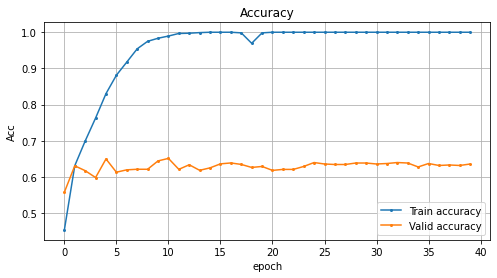

In [23]:
plt.figure(figsize = (8,4))
plt.plot(history['train_acc'],marker = 'o', ms = 2, label = "Train accuracy")
plt.plot(history['val_acc'],marker = 'o', ms = 2, label = "Valid accuracy")
plt.title(f'Accuracy');
plt.ylabel('Acc');
plt.xlabel('epoch')
plt.legend(), plt.grid()

(<matplotlib.legend.Legend at 0x7f65f09cc310>, None)

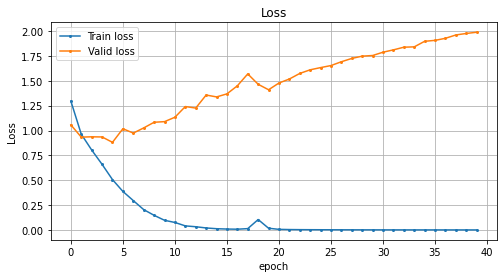

In [24]:
plt.figure(figsize = (8,4))
plt.plot(history['train_loss'],marker = 'o', ms = 2, label = "Train loss")
plt.plot(history['val_loss'],marker = 'o', ms = 2, label = "Valid loss")
plt.title(f'Loss');
plt.ylabel('Loss');
plt.xlabel('epoch')
plt.legend(), plt.grid()